In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("..")

from typing import NamedTuple

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import Array, jit

# OOP style

In [12]:
class Bandit:
    def select_action(key: Array, state: NamedTuple) -> Array: ...

    def update(state: NamedTuple, action: int, reward: float) -> NamedTuple: ...


class EpsilonGreedyState(NamedTuple):
    epsilon: float
    values: Array
    counts: Array


class EpsilonGreedy(Bandit):
    @staticmethod
    @jit
    def select_action(key: Array, state: EpsilonGreedyState) -> Array:
        key, subkey = jax.random.split(key)
        num_actions = state.values.shape[0]

        def explore():
            return jax.random.randint(subkey, shape=(), minval=0, maxval=num_actions)

        def exploit():
            return jnp.argmax(state.values)

        return jax.lax.cond(
            jax.random.uniform(key) < state.epsilon,
            explore,
            exploit,
        )

    @staticmethod
    @jit
    def update(state: EpsilonGreedyState, action: int, reward: float) -> EpsilonGreedyState:
        counts, values = state.counts, state.values

        counts_update = counts[action] + 1
        values_update = values[action] + (reward - values[action]) / counts_update

        counts = counts.at[action].set(counts_update)
        values = values.at[action].set(values_update)

        return EpsilonGreedyState(state.epsilon, values, counts)


class ThomsonSamplingState(NamedTuple):
    alpha: Array
    beta: Array


class ThomsonSampling(Bandit):
    @staticmethod
    @jit
    def select_action(key: Array, state: ThomsonSamplingState) -> Array:
        expected_rewards = jax.random.beta(key, state.alpha, state.beta)

        return jnp.argmax(expected_rewards)

    @staticmethod
    @jit
    def update(state: ThomsonSamplingState, action: int, reward: float) -> ThomsonSamplingState:
        alpha, beta = state.alpha, state.beta

        alpha_update = alpha[action] + reward
        beta_update = beta[action] + (1.0 - reward)

        alpha = alpha.at[action].set(alpha_update)
        beta = beta.at[action].set(beta_update)

        return ThomsonSamplingState(alpha, beta)

In [13]:
class Environment:
    def __init__(self, true_rewards: Array) -> None:
        self.true_rewards = true_rewards

    def run(self, key: Array, bandit: Bandit, init_state: NamedTuple, num_steps: int) -> tuple[NamedTuple, Array]:
        @jit
        def step(carry: tuple[NamedTuple, Array], key: Array) -> tuple[NamedTuple, Array]:
            bandit_state, true_rewards = carry
            key, subkey = jax.random.split(key)

            action = bandit.select_action(key, bandit_state)

            reward = jax.random.bernoulli(subkey, true_rewards[action]).astype(jnp.float32)

            bandit_state = bandit.update(bandit_state, action, reward)

            return (bandit_state, true_rewards), reward

        keys = jax.random.split(key, num_steps)
        (state, _), rewards = jax.lax.scan(step, (init_state, self.true_rewards), keys)

        return state, rewards

In [14]:
key = jax.random.key(1234)
num_actions = 10

key, subkey = jax.random.split(key)

true_probas = jax.random.uniform(subkey, num_actions)
env = Environment(true_probas)

In [22]:
greedy = EpsilonGreedy()
greedy_init_state = EpsilonGreedyState(
    epsilon=0.1,
    values=jnp.zeros(num_actions),
    counts=jnp.zeros(num_actions),
)

key, subkey = jax.random.split(key)

In [23]:
%%timeit
greedy_state, greedy_rewards = env.run(key, greedy, greedy_init_state, num_steps=10_000)

159 ms ± 8.49 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [159]:
ts = ThomsonSampling()
ts_init_state = ThomsonSamplingState(
    alpha=jnp.ones(num_actions),
    beta=jnp.ones(num_actions),
)

key, subkey = jax.random.split(key)
ts_state, ts_rewards = env.run(key, ts, ts_init_state, num_steps=10_000)

print(ts_rewards.mean())

0.9873


# Functional

## Stationary rewards

In [30]:
from src.bandits import environment
from src.bandits.data import stationary_rewards
from src.bandits.policies import epsilon_greedy, thomson_sampling, ucb
from src.bandits.utils import plot_rewards

key = jax.random.key(1234)

num_actions = 10
num_steps = 10_000
num_iter = 100

key, subkey = jax.random.split(key)

greedy_init_state = epsilon_greedy.EpsilonGreedyState(
    epsilon=0.3,
    epsilon_decay=0.99,
    values=jnp.zeros(num_actions),
    counts=jnp.zeros(num_actions),
)

ucb_init_state = ucb.UCBState(
    c=1.0,
    discount=1.0,
    steps=0.0,
    values=jnp.zeros(num_actions),
    counts=jnp.zeros(num_actions),
)

ts_init_state = thomson_sampling.ThomsonSamplingState(
    alphas=jnp.ones(num_actions),
    betas=jnp.ones(num_actions),
    discount=1.0,
)

key, *keys_algo = jax.random.split(key, 4)
policies = [
    (epsilon_greedy.select_action, epsilon_greedy.update_state, greedy_init_state),
    (ucb.select_action, ucb.update_state, ucb_init_state),
    (thomson_sampling.select_action, thomson_sampling.update_state, ts_init_state),
]

states, rewards = [], []
for subkey, (select_action_fn, update_state_fn, init_state) in zip(keys_algo, policies):
    state, reward = environment.simulate_multiple(
        subkey,
        select_action_fn,
        update_state_fn,
        init_state,
        num_actions,
        num_steps,
        num_iter,
        rewards_generator_fn=stationary_rewards,
        rewards_generator_fn_args=(),
    )
    states.append(state)
    rewards.append(reward)

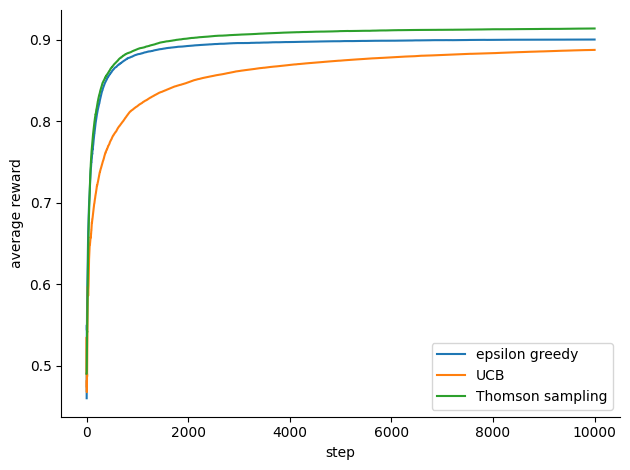

In [31]:
plot_rewards(rewards, ["epsilon greedy", "UCB", "Thomson sampling"])

## Non stationary rewards

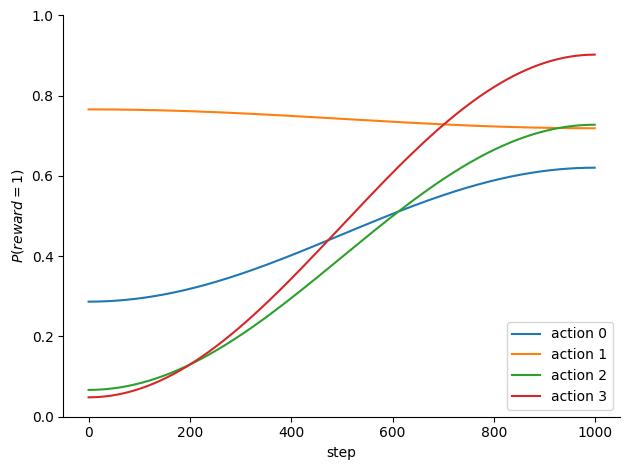

In [10]:
from src.bandits.data import (
    biregime_rewards,
    cosine_interpolation,
    multiregime_rewards,
)
from src.bandits.utils import plot_reward_probs

key = jax.random.key(123)
num_steps = 1_000
num_actions = 4

rewards_lin, p = biregime_rewards(key, num_steps, num_actions, cosine_interpolation)

plot_reward_probs(p)

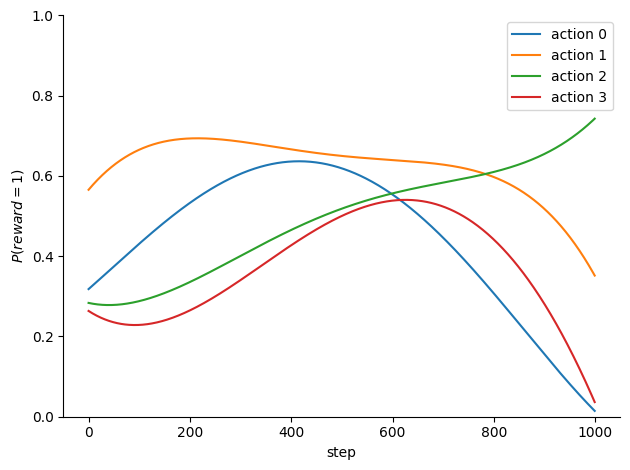

In [11]:
num_regimes = 5
rewards, p = multiregime_rewards(key, num_steps, num_actions, num_regimes)

plot_reward_probs(p)

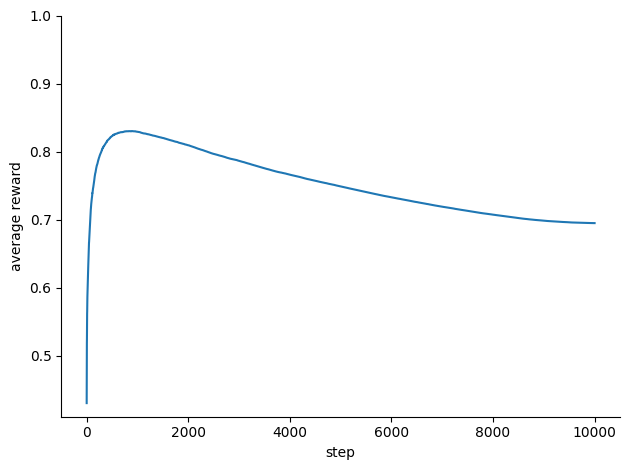

In [12]:
key = jax.random.key(123)
num_actions = 10
num_steps = 10_000
num_iter = 100


greedy_init_state = epsilon_greedy.EpsilonGreedyState(
    epsilon=0.3,
    epsilon_decay=0.99,
    values=jnp.zeros(num_actions),
    counts=jnp.zeros(num_actions),
)

greedy_state, greedy_rewards = environment.simulate_multiple(
    key,
    epsilon_greedy.select_action,
    epsilon_greedy.update_state,
    greedy_init_state,
    num_actions,
    num_steps,
    num_iter,
    rewards_generator_fn=multiregime_rewards,
    rewards_generator_fn_args=(3,),
)

step_inds = jnp.arange(1, num_steps + 1)
_, ax = plt.subplots()
ax.plot(jnp.cumsum(jnp.mean(greedy_rewards, axis=0)) / step_inds)

ax.set_xlabel("step")
ax.set_ylabel("average reward")
ax.set_ylim(top=1.0)
ax.spines[["right", "top"]].set_visible(False)


plt.tight_layout()

In [25]:
ts_init_state = thomson_sampling.ThomsonSamplingState(
    alphas=jnp.ones(num_actions),
    betas=jnp.ones(num_actions),
    discount=0.9,
)

policies = [
    (epsilon_greedy.select_action, epsilon_greedy.update_state, greedy_init_state),
    (ucb.select_action, ucb.update_state, ucb_init_state),
    (thomson_sampling.select_action, thomson_sampling.update_state, ts_init_state),
]

states, rewards = [], []
for subkey, (select_action_fn, update_state_fn, init_state) in zip(keys_algo, policies):
    state, reward = environment.simulate_multiple(
        subkey,
        select_action_fn,
        update_state_fn,
        init_state,
        num_actions,
        num_steps,
        num_iter,
        rewards_generator_fn=multiregime_rewards,
        rewards_generator_fn_args=(4,),
    )
    states.append(state)
    rewards.append(reward)

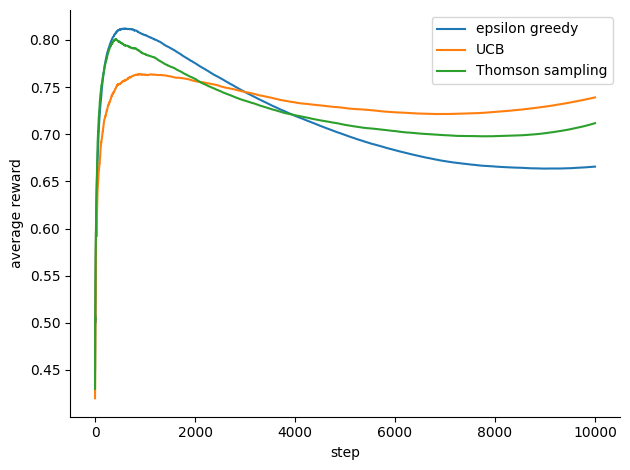

In [26]:
plot_rewards(rewards, ["epsilon greedy", "UCB", "Thomson sampling"])

### TODO: noisy non stationary

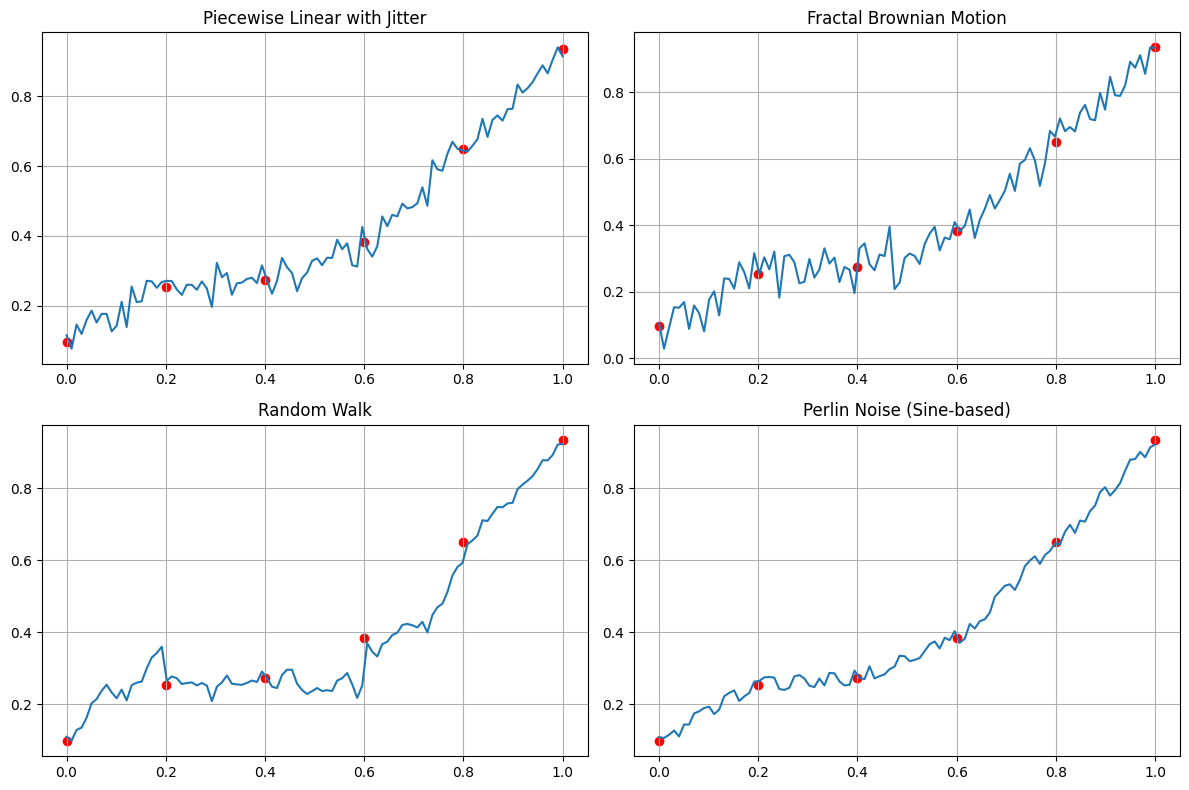

In [124]:
from jax import random

key = random.key(1234)
key, subkey = random.split(key, 2)

control_points = random.uniform(subkey, (6,))
n = 100


# 1. Piecewise Linear with Random Jitter
def noisy_linear_interpolation(control_points, n, noise_scale=0.1, key=None):
    m = control_points.shape[0]
    vectors_per_segment = n // (m - 1)

    if key is None:
        key = random.PRNGKey(0)

    interpolated_vectors = []
    for i in range(m - 1):
        start, end = control_points[i], control_points[i + 1]
        t = jnp.linspace(0, 1, vectors_per_segment)
        segment = (1 - t) * start + t * end

        # Add random noise to each interpolated point
        noise_key, key = random.split(key)
        noise = noise_scale * random.normal(noise_key, segment.shape)
        segment_noisy = segment + noise

        interpolated_vectors.append(segment_noisy)

    return jnp.hstack(interpolated_vectors)


# 2. Fractal Brownian Motion (fBM)
def fractal_brownian_motion(control_points, n, octaves=3, persistence=0.5, key=None):
    m = control_points.shape[0]
    vectors_per_segment = n // (m - 1)

    if key is None:
        key = random.PRNGKey(0)

    interpolated_vectors = []
    for i in range(m - 1):
        start, end = control_points[i], control_points[i + 1]
        t = jnp.linspace(0, 1, vectors_per_segment)
        segment = (1 - t) * start + t * end

        # Add fractal noise (fBM)
        fbm_noise = jnp.zeros_like(segment)
        frequency = 1.0
        amplitude = 0.02
        for _ in range(octaves):
            noise_key, key = random.split(key)
            noise = amplitude * random.normal(noise_key, segment.shape)
            fbm_noise += noise * frequency
            frequency *= 2.0
            amplitude *= persistence

        segment_noisy = segment + fbm_noise
        interpolated_vectors.append(segment_noisy)

    return jnp.hstack(interpolated_vectors)


# 3. Random Walk Interpolation
def random_walk_interpolation(control_points, n, noise_scale=0.1, key=None):
    m = control_points.shape[0]
    vectors_per_segment = n // (m - 1)

    if key is None:
        key = random.PRNGKey(0)

    interpolated_vectors = []
    for i in range(m - 1):
        start, end = control_points[i], control_points[i + 1]
        t = jnp.linspace(0, 1, vectors_per_segment)
        segment = (1 - t) * start + t * end

        # Add random walk noise
        noise_key, key = random.split(key)
        noise_steps = random.normal(noise_key, (vectors_per_segment,)) * noise_scale
        noise_walk = jnp.cumsum(noise_steps)

        segment_noisy = segment + noise_walk
        interpolated_vectors.append(segment_noisy)

    return jnp.hstack(interpolated_vectors)


# 4. Perlin Noise Interpolation (simplified sine-based)
def perlin_noise_interpolation(control_points, n, noise_scale=0.1, frequency=5.0, key=None):
    m = control_points.shape[0]
    vectors_per_segment = n // (m - 1)

    if key is None:
        key = random.PRNGKey(0)

    interpolated_vectors = []
    for i in range(m - 1):
        start, end = control_points[i], control_points[i + 1]
        t = jnp.linspace(0, 1, vectors_per_segment)
        segment = (1 - t) * start + t * end

        # Create Perlin-like noise by adding sine/cosine patterns with some random noise
        noise_key, key = random.split(key)
        noise = noise_scale * jnp.sin(frequency * t * 2 * jnp.pi + random.normal(noise_key, segment.shape))
        segment_noisy = segment + noise

        interpolated_vectors.append(segment_noisy)

    return jnp.hstack(interpolated_vectors)


# Generate interpolations
linear_jitter = noisy_linear_interpolation(control_points, n, noise_scale=0.03, key=key)
fbm_result = fractal_brownian_motion(control_points, n, octaves=4, persistence=0.5, key=key)
random_walk_result = random_walk_interpolation(control_points, n, noise_scale=0.02, key=key)
perlin_result = perlin_noise_interpolation(control_points, n, noise_scale=0.02, frequency=3.0, key=key)

# Plot results
x = jnp.linspace(0, 1, n)

plt.figure(figsize=(12, 8))

# Noisy linear interpolation
plt.subplot(2, 2, 1)
plt.plot(x, linear_jitter, label="Noisy Linear")
plt.scatter(jnp.linspace(0, 1, len(control_points)), control_points, color="red")
plt.title("Piecewise Linear with Jitter")
plt.grid(True)

# Fractal Brownian Motion
plt.subplot(2, 2, 2)
plt.plot(x, fbm_result, label="fBM")
plt.scatter(jnp.linspace(0, 1, len(control_points)), control_points, color="red")
plt.title("Fractal Brownian Motion")
plt.grid(True)

# Random Walk
plt.subplot(2, 2, 3)
plt.plot(x, random_walk_result, label="Random Walk")
plt.scatter(jnp.linspace(0, 1, len(control_points)), control_points, color="red")
plt.title("Random Walk")
plt.grid(True)

# Perlin Noise
plt.subplot(2, 2, 4)
plt.plot(x, perlin_result, label="Perlin Noise")
plt.scatter(jnp.linspace(0, 1, len(control_points)), control_points, color="red")
plt.title("Perlin Noise (Sine-based)")
plt.grid(True)

plt.tight_layout()
plt.show()